In [3]:
from importlib.metadata import version

import torch

torch.manual_seed(123)
print("TORCH VERSION :", version("torch"))
device = (
    "cuda" if torch.cuda.is_available() else "mps" if torch.backend.mps.is_available() else "cpu"
)
print("GPU  : ", device)

TORCH VERSION : 2.2.0
GPU  :  cuda


In [4]:
import torch.nn as nn
import torch.nn.functional as F

In [25]:
# Naive Self Attention Implementation
inputs = torch.rand(3, 5)
print(inputs)
print(inputs.T)
attention_scores = inputs @ inputs.T
attention_weights = F.softmax(attention_scores, dim=-1)
print("output >>")
attention_weights @ inputs

tensor([[0.1365, 0.7625, 0.1632, 0.6641, 0.1525],
        [0.9830, 0.5936, 0.9120, 0.0146, 0.6323],
        [0.4743, 0.7467, 0.3545, 0.9994, 0.9815]])
tensor([[0.1365, 0.9830, 0.4743],
        [0.7625, 0.5936, 0.7467],
        [0.1632, 0.9120, 0.3545],
        [0.6641, 0.0146, 0.9994],
        [0.1525, 0.6323, 0.9815]])
output >>


tensor([[0.4921, 0.7153, 0.4283, 0.6645, 0.6471],
        [0.7396, 0.6576, 0.6645, 0.3794, 0.6854],
        [0.5362, 0.7146, 0.4505, 0.7238, 0.7720]])

#### This self-attention mechanism is also called "scaled dot-product attention".

In [6]:
# Self attention implementation with trainable weights


class SingleHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, blocksize, dropout=0.0, mask=False, qkv_bias=False):
        super().__init__()

        self.w_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.w_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.w_value = nn.Linear(d_in, d_out, bias=qkv_bias)

        self.dropout = nn.Dropout(dropout)
        if mask:
            self.register_buffer("mask", torch.triu(torch.ones(blocksize, blocksize), diagonal=1))

    def forward(self, x):
        batch, token_count, _ = x.shape

        queries = self.w_query(x)
        keys = self.w_key(x)
        values = self.w_value(x)

        attention_scores = queries @ keys.transpose(1, 2)

        if hasattr(self, "mask"):
            attention_scores.masked_fill_(self.mask.bool()[:token_count, :token_count], -torch.inf)

        attention_weights = F.softmax(attention_scores / keys.shape[-1] ** 0.5, dim=-1)
        attention_weights = self.dropout(attention_weights)
        context_vector = attention_weights @ values
        return context_vector

In [20]:
inp = torch.rand(1, 8, 12)
d_in = d_out = inp.shape[-1]
sha = SingleHeadAttention(d_in, d_out, inp.shape[1], mask=True)
result = sha(inp)
result.shape

torch.Size([1, 8, 12])

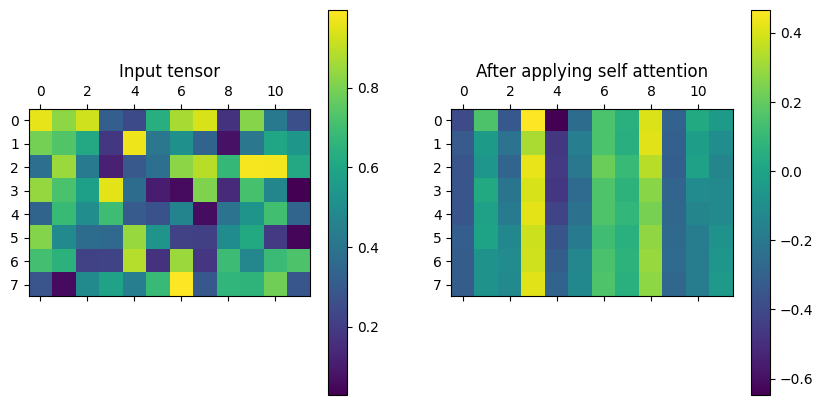

In [26]:
def plot(inp, result):
    import matplotlib.pyplot as plt

    # Create a figure with two subplots side by side
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Plot the same plot on both subplots
    cax1 = axs[0].matshow(inp.squeeze(0))
    fig.colorbar(cax1, ax=axs[0])
    cax2 = axs[1].matshow(result.detach().numpy().squeeze(0))
    fig.colorbar(cax2, ax=axs[1])

    axs[0].set_title("Input tensor")
    axs[1].set_title("After applying self attention")

    # Show the plot
    plt.show()


plot(inp, result)
# TODO: REVISIT AFTER MODEL TRAINING

In [27]:
# Multi Head Self Attention


class MultiHeadAttention_v1(nn.Module):
    def __init__(self, heads, d_in, d_out, blocksize, dropout=0.0, mask=False, qkv_bias=False):
        super().__init__()
        self.heads = nn.ModuleList(
            [
                SingleHeadAttention(d_in, d_out, blocksize, dropout, mask, qkv_bias)
                for _ in range(heads)
            ]
        )

        self.linear = nn.Linear(d_out * heads, d_out * heads)

    def forward(self, x):
        context_vec = torch.cat([head(x) for head in self.heads], dim=-1)
        return self.linear(context_vec)

In [32]:
# for embedding_dim = 512 , head = 8
# d_in = 512/8 = 64


mha = MultiHeadAttention_v1(2, 12, 18, 10)
result = mha(inp)
result.shape

torch.Size([1, 8, 36])

In [9]:
# plot(inp,result)

In [33]:
class MultiHeadAttention(SingleHeadAttention):
    def __init__(self, num_heads, d_model, blocksize, dropout=0.0, mask=False, qkv_bias=False):
        super().__init__(d_model, d_model, blocksize, dropout, mask, qkv_bias)
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads

        self.linear = nn.Linear(d_model, d_model)

    def forward(self, x):
        batch, num_token, embedding_dim = x.shape

        queries = self.w_query(x)
        keys = self.w_key(x)
        values = self.w_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        queries = queries.view(batch, num_token, self.num_heads, self.head_dim).transpose(1, 2)
        keys = keys.view(batch, num_token, self.num_heads, self.head_dim).transpose(1, 2)
        values = values.view(batch, num_token, self.num_heads, self.head_dim).transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attention_scores = torch.matmul(queries, keys.transpose(-2, -1))
        if hasattr(self, "mask"):
            attention_scores.masked_fill_(self.mask.bool()[:num_token, :num_token], -float("inf"))

        attention_weights = F.softmax(attention_scores / keys.shape[-1] ** 0.5, dim=-1)
        attention_weights = self.dropout(attention_weights)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vector = torch.matmul(attention_weights, values)
        context_vector = (
            context_vector.transpose(1, 2).contiguous().view(batch, num_token, embedding_dim)
        )
        return self.linear(context_vector)

In [34]:
mha = MultiHeadAttention(2, 12, 10)
result = mha(inp)
result.shape

torch.Size([1, 8, 12])

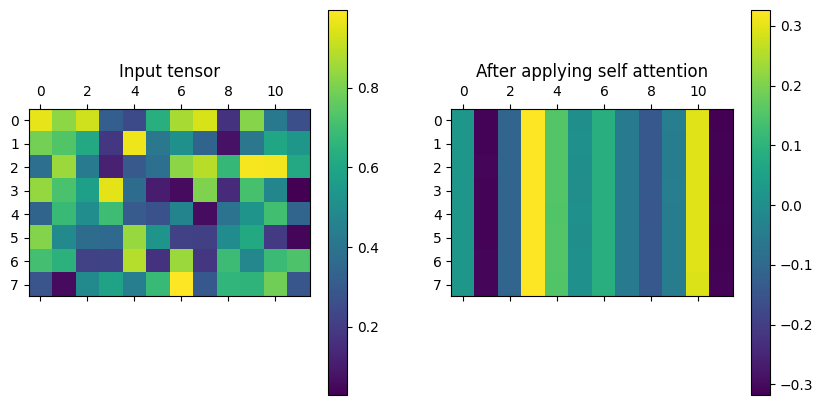

In [35]:
plot(inp, result)

In [36]:
class MultiHeadAttentionPyTorchSDP(nn.Module):
    def __init__(self, num_heads, d_model, block_size, mask=False, dropout=0.0, qkv_bias=False):
        super().__init__()

        assert d_model % num_heads == 0, "embed_dim is indivisible by num_heads"

        self.num_heads = num_heads
        self.block_size = block_size
        self.head_dim = d_model // num_heads
        self.d_model = d_model

        self.qkv = nn.Linear(d_model, 3 * d_model, bias=qkv_bias)
        self.proj = nn.Linear(d_model, d_model)
        self.dropout = dropout

        self.register_buffer("mask", torch.triu(torch.ones(block_size, block_size), diagonal=1))

    def forward(self, x):
        batch_size, num_tokens, embed_dim = x.shape

        # (b, num_tokens, embed_dim) --> (b, num_tokens, 3 * embed_dim)
        qkv = self.qkv(x)

        # (b, num_tokens, 3 * embed_dim) --> (b, num_tokens, 3, num_heads, head_dim)
        qkv = qkv.reshape(batch_size, num_tokens, 3, self.num_heads, self.head_dim)

        # (b, num_tokens, 3, num_heads, head_dim) --> (3, b, num_heads, num_tokens, head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)

        # (3, b, num_heads, num_tokens, head_dim) -> 3 times (b, num_heads, num_tokens, head_dim)
        queries, keys, values = qkv.unbind(0)

        use_dropout = 0.0 if not self.training else self.dropout
        context_vec = nn.functional.scaled_dot_product_attention(
            queries, keys, values, attn_mask=None, dropout_p=use_dropout, is_causal=True
        )

        # Combine heads, where self.d_model = self.num_heads * self.head_dim
        context_vec = (
            context_vec.transpose(1, 2).contiguous().view(batch_size, num_tokens, embed_dim)
        )

        return context_vec

In [37]:
mhap = MultiHeadAttentionPyTorchSDP(2, 12, 10)
result = mhap(inp)
result.shape

torch.Size([1, 8, 12])

In [39]:
# plot(inp,result)

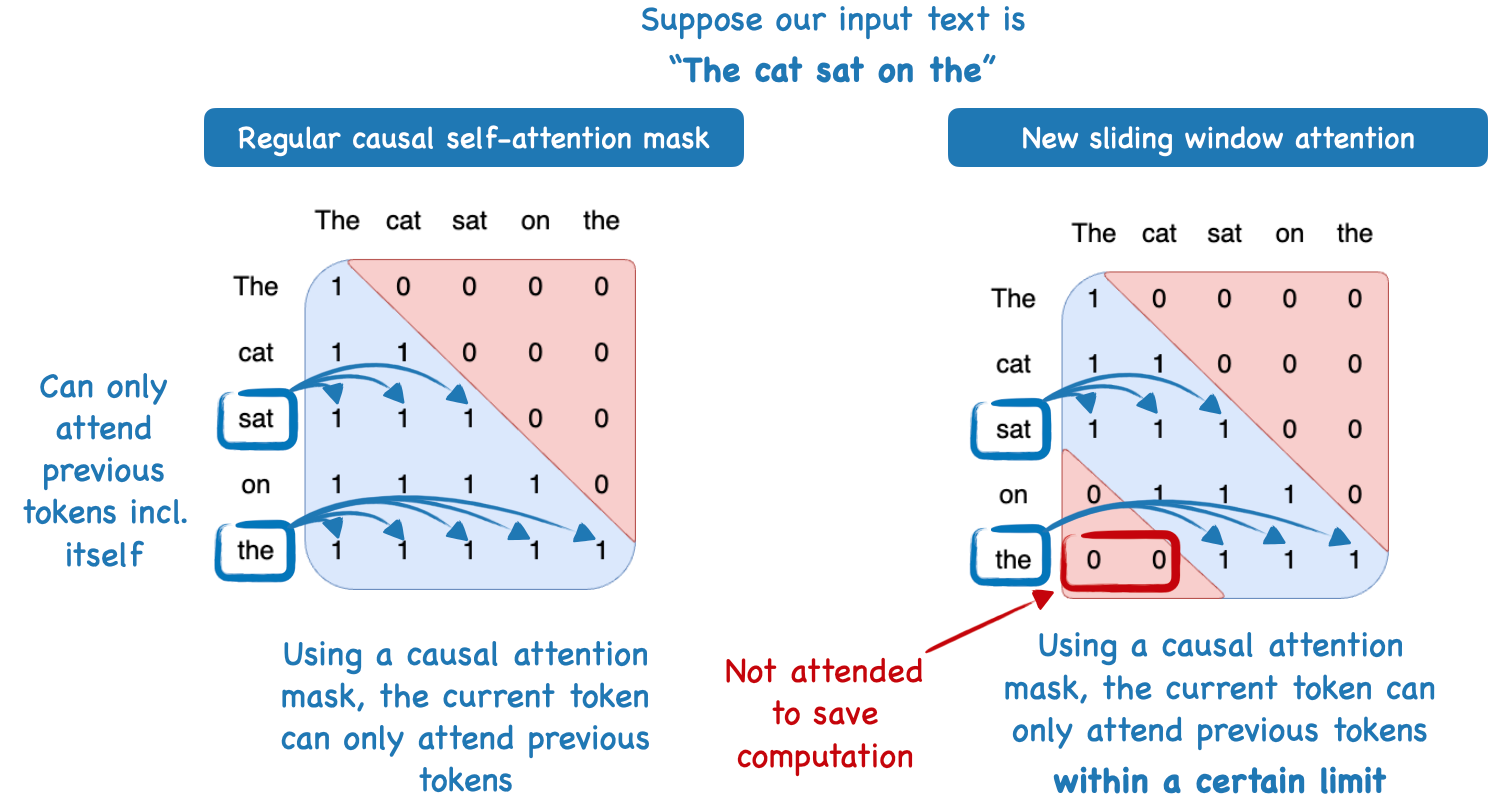
https://magazine.sebastianraschka.com/p/research-papers-october-2023

### Benchmark Test - CPU

In [17]:
torch.manual_seed(12345)
batch = 32
max_len = 1024
embedding_dim = 768
num_heads = 12

x = torch.rand(batch, max_len, embedding_dim)

In [18]:
%timeit SingleHeadAttention(embedding_dim,embedding_dim,x.shape[1],mask=True)(x)

293 ms ± 8.85 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
%timeit MultiHeadAttention_v1(num_heads,embedding_dim,embedding_dim//num_heads,max_len)(x)

676 ms ± 31 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
%timeit MultiHeadAttention(num_heads,embedding_dim,max_len)(x)

698 ms ± 33.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
%timeit MultiHeadAttentionPyTorchSDP(num_heads,embedding_dim,max_len)(x)

241 ms ± 5.37 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### GPU Benchmark Test

In [23]:
x = x.to(device)

In [24]:
%timeit SingleHeadAttention(embedding_dim,embedding_dim,x.shape[1],mask=True).to(device)(x)

11 ms ± 1.65 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [25]:
x = x.to(device)
%timeit MultiHeadAttention_v1(num_heads,embedding_dim,embedding_dim//num_heads,max_len).to(device)(x)

37.1 ms ± 691 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [26]:
%timeit MultiHeadAttention(num_heads,embedding_dim,max_len).to(device)(x)

32.8 ms ± 908 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [27]:
%timeit MultiHeadAttentionPyTorchSDP(num_heads,embedding_dim,max_len).to(device)(x)

10.9 ms ± 20.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [28]:
%timeit nn.Linear(embedding_dim,embedding_dim).to(device)(nn.MultiheadAttention(embedding_dim, num_heads).to(device)(x,x,x)[0])

18 ms ± 9.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [29]:
torch.cuda.empty_cache()

In [30]:
import pytorch_benchmark

model = MultiHeadAttentionPyTorchSDP(num_heads, embedding_dim, max_len).to("cuda")

# Create a benchmark object
results = pytorch_benchmark.benchmark(
    model, sample=x.to("cuda"), num_runs=10, batch_size=32, print_details=True
)

Warming up with batch_size=1: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 675.52it/s]


Warning! No positional inputs found for a module, assuming batch size is 1.
MultiHeadAttentionPyTorchSDP(
  2.36 M, 100.000% Params, 1.81 GMac, 100.000% MACs, 
  (qkv): Linear(1.77 M, 74.976% Params, 1.81 GMac, 100.000% MACs, in_features=768, out_features=2304, bias=False)
  (proj): Linear(590.59 k, 25.024% Params, 0.0 Mac, 0.000% MACs, in_features=768, out_features=768, bias=True)
)


Warming up with batch_size=1: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 844.26it/s]
STAGE:2024-05-02 00:47:26 139476:139476 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-05-02 00:47:26 139476:139476 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-05-02 00:47:26 139476:139476 ActivityProfilerController.cpp:324] Completed Stage: Post Processing
Measuring inference for batch_size=1: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 544.64it/s]
Unable to measure energy consumption. Device must be a NVIDIA Jetson.
Warming up with batch_size=32: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.74it/s]
STAGE:2024-05-02 00:47:26 139476:139476 ActivityProfilerController.cpp:314] Completed Stage

In [32]:
import yaml

print(yaml.dump(results))

device: cuda
flops: 1811939328
machine_info:
  cpu:
    architecture: x86_64
    cores:
      physical: 24
      total: 32
    frequency: 4.79 GHz
    model: 13th Gen Intel(R) Core(TM) i9-13900F
  gpus:
  - memory: 12282.0 MB
    name: NVIDIA GeForce RTX 4070 Ti
  memory:
    available: 22.17 GB
    total: 31.06 GB
    used: 8.29 GB
  system:
    node: pranav-pc-Legion-T5-26IRB8
    release: 6.5.0-28-generic
    system: Linux
memory:
  batch_size_1:
    max_inference: 133.13 MB
    max_inference_bytes: 139594752
    post_inference: 117.13 MB
    post_inference_bytes: 122817536
    pre_inference: 117.13 MB
    pre_inference_bytes: 122817536
  batch_size_32:
    max_inference: 597.13 MB
    max_inference_bytes: 626134016
    post_inference: 117.13 MB
    post_inference_bytes: 122817536
    pre_inference: 117.13 MB
    pre_inference_bytes: 122817536
params: 2360064
timing:
  batch_size_1:
    cpu_to_gpu:
      human_readable:
        batch_latency: 554.061 us +/- 76.428 us [500.202 us, 76